In [11]:
import re
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt

def clean_generated_text(text, min_words=20):
    """
    Post generation cleaning:
      - Removes text after instruction tokens (e.g. '###')
      - Checks for excessive non-alphabet characters (possible gibberish)
      - Checks for excessive repetition in sentence structure
      - Flags long sequences of mathematical or operator expressions.
    Returns an empty string if any check fails.
    """
    if not isinstance(text, str):
        return ""
    
    # remove instruction artifacts
    text = re.sub(r'###.*', '', text, flags=re.DOTALL)
    text = text.strip()
    
    if not text:
        return ""
    
    # ratio of non-letter characters
    total_chars = len(text)
    letters = sum(1 for c in text if c.isalpha())
    if total_chars > 0 and (total_chars - letters) / total_chars > 0.5:
        return ""
    
    # check for sentence repetition, at least half are unique
    sentences = sent_tokenize(text)
    if sentences:
        unique_sentences = set(sentences)
        if len(unique_sentences) / len(sentences) < 0.5:
            return ""
    
    # check sequences of math-like/operator patterns
    math_pattern = r'(?:[A-Za-z]\s*(?:\+|\-|\*|\/)\s*){5,}'
    if re.search(math_pattern, text):
        return ""
    
    # check that text isn’t unusually short/incomplete
    if len(word_tokenize(text)) < min_words:
        return ""
    
    return text

def batch_count_words_and_sentences(texts):
    """
    Tokenizes the text into words and sentences using nltk 
    Returns a tuple of (n_words,n_sentences)
    """
    return [(len(word_tokenize(text)), len(sent_tokenize(text))) for text in texts]

In [12]:
# File paths
wiki_path = "src/wiki_dataset_generated.csv"
wiki_clean_path = "src/wiki_dataset_clean.csv"

news_path = "src/news_dataset_generated.csv"
news_clean_path = "src/news_dataset_clean.csv"

abstracts_path = "src/abstracts_dataset_generated.csv"
abstracts_clean_path = "src/abstracts_dataset_clean.csv"

# Load datasets
wiki_df = pd.read_csv(wiki_path)[0:1500]
news_df = pd.read_csv(news_path)[0:1500]
abstracts_df = pd.read_csv(abstracts_path)[0:1500]

# Clean the generated text
for df in [wiki_df, news_df, abstracts_df]:
    df['Llama3.1_clean'] = df['Llama3.1'].apply(clean_generated_text)
    df['Falcon_clean'] = df['Falcon'].apply(clean_generated_text)

# Calculate word and sentence counts for cleaned articles
wiki_df['Llama3.1_clean_len'] = batch_count_words_and_sentences(wiki_df['Llama3.1_clean'])
wiki_df['Falcon_clean_len'] = batch_count_words_and_sentences(wiki_df['Falcon_clean'])

news_df['Llama3.1_clean_len'] = batch_count_words_and_sentences(news_df['Llama3.1_clean'])
news_df['Falcon_clean_len'] = batch_count_words_and_sentences(news_df['Falcon_clean'])

abstracts_df['Llama3.1_clean_len'] = batch_count_words_and_sentences(abstracts_df['Llama3.1_clean'])
abstracts_df['Falcon_clean_len'] = batch_count_words_and_sentences(abstracts_df['Falcon_clean'])


In [13]:
# Save the cleaned dataset
wiki_df.to_csv(wiki_clean_path, index=False)
news_df.to_csv(news_clean_path, index=False)
abstracts_df.to_csv(abstracts_clean_path, index=False)

In [15]:
### Analysis of generated datasets ###

In [16]:
def analyze_lengths(dataset_name, df):
    """
    Analyzes lengths (word and sentence counts) for human vs generated text.
    Adds separate rows for word and sentence average differences for better readability.
    """
    print(f"\n--- {dataset_name} Analysis ---")
    
    # Convert columns to 2D np.arrays
    human_lengths = np.array(df['human_len'].apply(eval).tolist()) 
    llama_lengths = np.array(df['Llama3.1_clean_len'].apply(eval).tolist())
    falcon_lengths = np.array(df['Falcon_clean_len'].apply(eval).tolist())
    gpt_lengths = np.array(df['gpt_len'].apply(eval).tolist())
    
    def compute_stats(lengths):
        word_counts = lengths[:, 0]
        sentence_counts = lengths[:, 1]
        return {
            'Min': (np.min(word_counts), np.min(sentence_counts)),
            'Max': (np.max(word_counts), np.max(sentence_counts)),
            'Avg': (round(np.mean(word_counts), 3), round(np.mean(sentence_counts), 3)),
            'Median': (np.median(word_counts), np.median(sentence_counts))
        }
    
    def compute_diff(human, generated):
        word_diff = generated[:, 0] - human[:, 0]
        sentence_diff = generated[:, 1] - human[:, 1]
        avg_diff = (round(np.mean(word_diff), 3), round(np.mean(sentence_diff), 3))
        proportional_diff = (
            round(np.mean(word_diff / human[:, 0]) * 100, 3),
            round(np.mean(sentence_diff / human[:, 1]) * 100, 3)
        )
        return avg_diff, proportional_diff

    # Compute statistics for human and generated text
    human_stats = compute_stats(human_lengths)
    llama_stats = compute_stats(llama_lengths)
    falcon_stats = compute_stats(falcon_lengths)
    gpt_stats = compute_stats(gpt_lengths)

    # Compute average differences
    gpt_avg_diff, gpt_prop_diff = compute_diff(human_lengths, gpt_lengths)
    llama_avg_diff, llama_prop_diff = compute_diff(human_lengths, llama_lengths)
    falcon_avg_diff, falcon_prop_diff = compute_diff(human_lengths, falcon_lengths)

    # Print table with added average differences
    print(f"{'Metric':<20}{'Human':<20}{'GPT':<20}{'Llama 3.1':<20}{'Falcon':<20}")
    for metric in ['Min', 'Max', 'Avg', 'Median']:
        human = human_stats[metric]
        gpt = gpt_stats[metric]
        llama = llama_stats[metric]
        falcon = falcon_stats[metric]
        print(f"{metric:<20}{str(human):<20}{str(gpt):<20}{str(llama):<20}{str(falcon):<20}")
    
    # Add separate rows for average differences
    print(f"{'avg_word_diff':<20}{'-':<20}"
          f"{f'{gpt_avg_diff[0]},{gpt_prop_diff[0]}%':<20}"
          f"{f'{llama_avg_diff[0]},{llama_prop_diff[0]}%':<20}"
          f"{f'{falcon_avg_diff[0]},{falcon_prop_diff[0]}%':<20}")
    print(f"{'avg_sentence_diff':<20}{'-':<20}"
          f"{f'{gpt_avg_diff[1]},{gpt_prop_diff[1]}%':<20}"
          f"{f'{llama_avg_diff[1]},{llama_prop_diff[1]}%':<20}"
          f"{f'{falcon_avg_diff[1]},{falcon_prop_diff[1]}%':<20}")
    
    def plot_histogram(data, label, ax, bins, alpha=0.5):
        ax.hist(data[:, 0], bins=bins, alpha=alpha, label=f"{label} - Word Count")
        ax.hist(data[:, 1], bins=bins, alpha=alpha, label=f"{label} - Sentence Count")
        ax.legend()

    word_bins = 40 
    sen_bins = 20
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for word and sentence count
    
    axes[0].hist(human_lengths[:, 0], bins=word_bins, alpha=0.5, label="Human")
    axes[0].hist(llama_lengths[:, 0], bins=word_bins, alpha=0.5, label="Llama 3.1")
    axes[0].hist(falcon_lengths[:, 0], bins=word_bins, alpha=0.5, label="Falcon")
    if gpt_lengths is not None:
        axes[0].hist(gpt_lengths[:, 0], bins=word_bins, alpha=0.5, label="GPT")
    axes[0].set_title(f"{dataset_name} - Word Count")
    axes[0].set_xlabel("Word Count")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()

    axes[1].hist(human_lengths[:, 1], bins=sen_bins, alpha=0.5, label="Human")
    axes[1].hist(llama_lengths[:, 1], bins=sen_bins, alpha=0.5, label="Llama 3.1")
    axes[1].hist(falcon_lengths[:, 1], bins=sen_bins, alpha=0.5, label="Falcon")
    if gpt_lengths is not None:
        axes[1].hist(gpt_lengths[:, 1], bins=sen_bins, alpha=0.5, label="GPT")
    axes[1].set_title(f"{dataset_name} - Sentence Count")
    axes[1].set_xlabel("Sentence Count")
    axes[1].set_ylabel("Frequency")
    axes[1].legend()

    plt.tight_layout()
    plt.show()



--- Wikipedia Dataset Analysis ---
Metric              Human               GPT                 Llama 3.1           Falcon              
Min                 (152, 1)            (67, 8)             (147, 4)            (0, 0)              
Max                 (422, 30)           (304, 19)           (509, 37)           (437, 32)           
Avg                 (223.833, 9.057)    (236.238, 12.031)   (264.576, 10.491)   (182.836, 8.725)    
Median              (209.0, 9.0)        (243.0, 12.0)       (236.0, 9.0)        (178.0, 8.0)        
avg_word_diff       -                   12.405,9.663%       40.743,17.201%      -40.997,-15.615%    
avg_sentence_diff   -                   2.974,47.764%       1.434,19.155%       -0.332,6.161%       


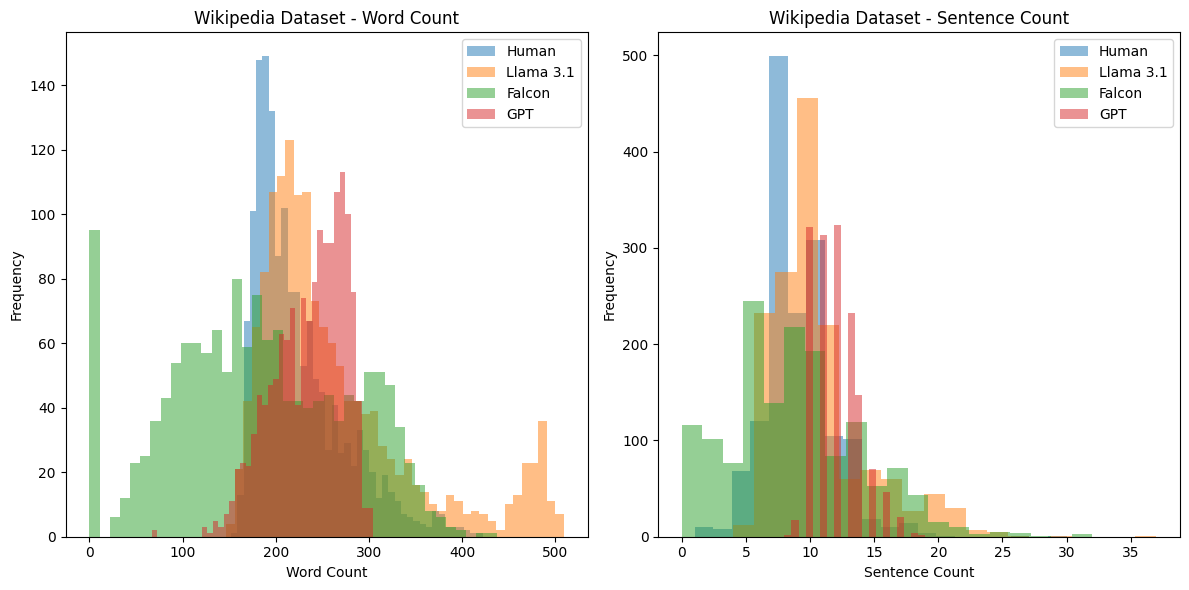


--- News Dataset Analysis ---
Metric              Human               GPT                 Llama 3.1           Falcon              
Min                 (264, 9)            (273, 13)           (0, 0)              (0, 0)              
Max                 (636, 56)           (703, 36)           (1033, 59)          (740, 241)          
Avg                 (474.346, 22.966)   (448.438, 18.675)   (654.039, 26.827)   (275.38, 17.025)    
Median              (482.0, 22.0)       (444.0, 18.0)       (647.0, 26.0)       (248.0, 13.0)       
avg_word_diff       -                   -25.908,-4.756%     179.693,38.581%     -198.966,-41.225%   
avg_sentence_diff   -                   -4.291,-13.179%     3.861,22.057%       -5.941,-22.406%     


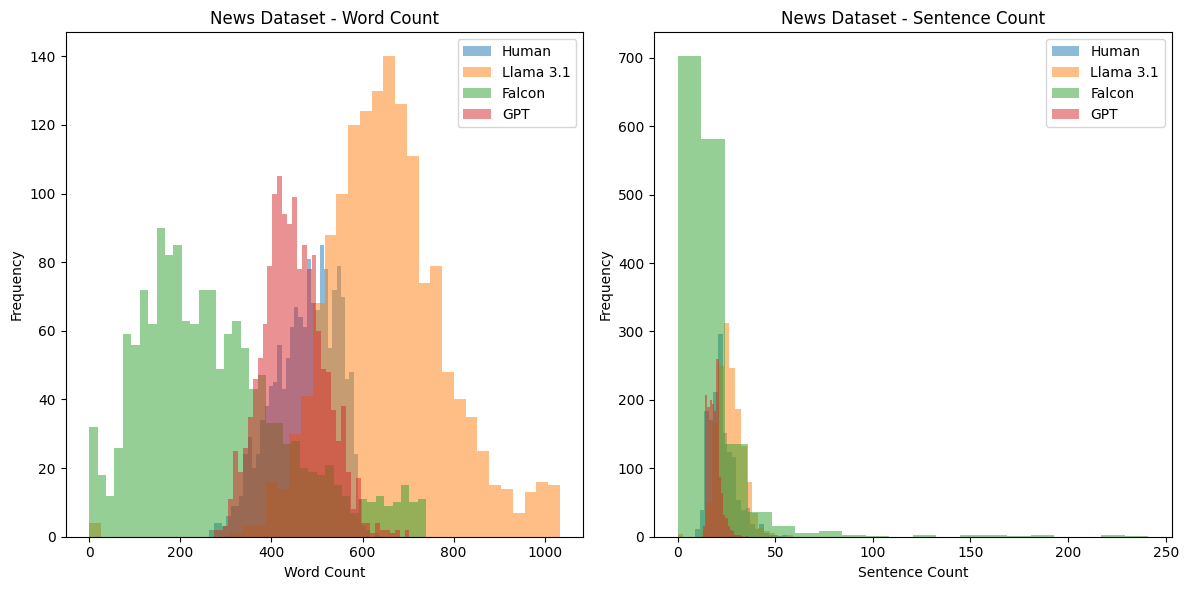


--- Abstracts Dataset Analysis ---
Metric              Human               GPT                 Llama 3.1           Falcon              
Min                 (176, 1)            (205, 7)            (0, 0)              (0, 0)              
Max                 (851, 35)           (516, 22)           (579, 35)           (375, 32)           
Avg                 (432.873, 12.423)   (332.499, 12.841)   (466.679, 16.829)   (170.439, 6.808)    
Median              (410.0, 12.0)       (330.0, 13.0)       (468.0, 17.0)       (174.0, 6.0)        
avg_word_diff       -                   -100.374,-21.019%   33.805,10.621%      -262.434,-59.462%   
avg_sentence_diff   -                   0.419,13.801%       4.406,46.951%       -5.615,-40.445%     


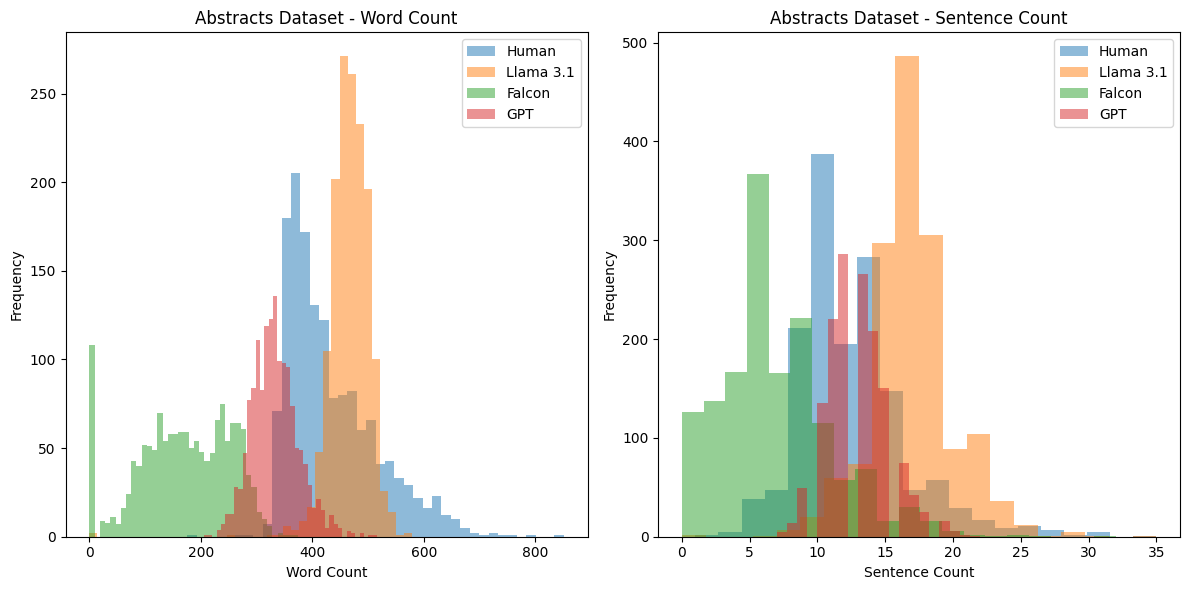

In [17]:
# Load cleaned datasets
wiki_clean = pd.read_csv("src/wiki_dataset_clean.csv")
news_clean = pd.read_csv("src/news_dataset_clean.csv")
abstracts_clean = pd.read_csv("src/abstracts_dataset_clean.csv")

# Analyze lengths for each dataset
analyze_lengths("Wikipedia Dataset", wiki_clean)
analyze_lengths("News Dataset", news_clean)
analyze_lengths("Abstracts Dataset", abstracts_clean)

In [19]:
def debug_flagged_rows(df, models, percentile=5):
    """
    Fixes and debugs the flagging of rows with extreme lengths.
    Adds the `bad_length` column with the correct model names.
    """
    df['bad_length'] = None  # Initialize the column

    # Safely parse human lengths
    human_lengths = np.array(
        df['human_len'].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()
    )

    for model in models:
        # Safely parse model lengths
        generated_lengths = np.array(
            df[model].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()
        )
        word_diff = generated_lengths[:, 0] - human_lengths[:, 0]  # Word count difference

        # Calculate thresholds
        low_threshold = np.percentile(word_diff, percentile)
        high_threshold = np.percentile(word_diff, 100 - percentile)

        # Debugging: Output thresholds
        print(f"Model: {model}")
        print(f"  Low Threshold: {low_threshold}")
        print(f"  High Threshold: {high_threshold}")

        # Identify rows with extreme word differences
        extreme_mask = (word_diff < low_threshold) | (word_diff > high_threshold)
        flagged_indices = np.where(extreme_mask)[0]

        # Debugging: Output indices and differences
        print(f"  Flagged Indices: {flagged_indices}")
        for idx in flagged_indices:
            print(f"    Row {idx}: Human Words = {human_lengths[idx, 0]}, "
                  f"Model Words = {generated_lengths[idx, 0]}, Difference = {word_diff[idx]}")

        # Update bad_length column
        df.loc[extreme_mask, 'bad_length'] = df.loc[extreme_mask, 'bad_length'].fillna('') + model.replace('_len', '') + '; '

    # Clean up trailing semicolons
    df['bad_length'] = df['bad_length'].str.strip('; ')

    # Output final flagged rows for verification
    flagged_rows = df[df['bad_length'].notnull()]
    print("\nFinal Flagged Rows:")
    print(flagged_rows[['human_len', *models, 'bad_length']])
    return df


In [20]:
models_to_check = ['gpt_len', 'Llama3.1_clean_len', 'Falcon_clean_len']
# Apply debugging to flagged rows
debugged_df = debug_flagged_rows(df, models_to_check)


Model: gpt_len
  Low Threshold: -103.05
  High Threshold: 93.04999999999995
  Flagged Indices: [   9   35   41   52   66   69   71   83   87  102  103  122  134  136
  141  142  163  188  199  210  241  252  253  258  265  284  288  323
  335  338  360  377  397  404  405  407  409  427  430  438  440  445
  447  456  468  476  483  491  494  500  525  552  558  576  614  619
  620  634  635  650  652  662  665  676  678  700  701  704  725  774
  779  785  786  789  795  805  808  822  846  880  886  902  907  914
  925  931  954  963  964  975  981  987  991  998  999 1001 1003 1005
 1009 1011 1030 1032 1034 1043 1048 1062 1071 1079 1083 1094 1100 1103
 1106 1115 1139 1171 1172 1175 1185 1195 1211 1213 1228 1230 1242 1262
 1277 1278 1284 1306 1324 1325 1328 1332 1335 1347 1358 1375 1378 1387
 1400 1419 1423 1428 1438 1453 1469 1481 1489 1497]
    Row 9: Human Words = 265, Model Words = 148, Difference = -117
    Row 35: Human Words = 162, Model Words = 266, Difference = 104
    Row 4